In [2]:
import requests
import inspect
import pytz
import pandas as pd
import numpy as np

from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from time import ctime   # ctime converts epoch time (ex:1661522400) to string form (Thu Aug 25 16:00:00 2022)
from time import gmtime   # Convert a time expressed in seconds since the epoch to a struct_time in UTC in which the dst flag is always zero.
from time import localtime # Like gmtime() but converts to local time.

from datetime import datetime, timedelta
today = datetime.now()
import datetime as dt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 20




### 2 fichiers créés par node-red et mis à jour toutes les heures avec openweather node dans onglet Temp/Hum

#### json_file ="C:/Users/jean/OneDrive/Bureau/5days.txt"

#### json_file ="Y:/Documents/5days.txt"

#### le fichier contient une liste de 40 lignes :
- une ligne = 3 heures, 
- 8 lignes par jour 
- sur 5 jours


In [3]:
try:
    json_file = "Y:/Documents/5days.txt"  # pc cuisine
    current = pd.read_json(json_file)
except:
    json_file = "Z:/Documents/5days.txt"  # pc chambre
    current = pd.read_json(json_file)

In [4]:
#current['dates'] = [datetime.fromtimestamp(current.dt[k], pytz.timezone('Europe/Paris')) for k in range(40)]
current['dates'] = [datetime.fromtimestamp(current.dt[k]) for k in range(40)]
current['h_date'] = [datetime.fromtimestamp(current.dt[k]).strftime('%d/%m/%Y %H:%M:%S') for k in range(40)]
current['h_time'] = [datetime.fromtimestamp(current.dt[k]).strftime('%H') for k in range(40)]
current


,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,dt,dates,h_date,h_time
0,8.55,6.22,8.12,8.55,994,994,988,89,0.43,1710018000,2024-03-09 22:00:00,09/03/2024 22:00:00,22
1,7.95,5.11,7.54,7.95,994,994,987,86,0.41,1710028800,2024-03-10 01:00:00,10/03/2024 01:00:00,01
2,7.53,6.20,7.53,7.53,993,993,986,87,0.00,1710039600,2024-03-10 04:00:00,10/03/2024 04:00:00,04
3,7.29,7.29,7.29,7.29,993,993,986,89,0.00,1710050400,2024-03-10 07:00:00,10/03/2024 07:00:00,07
4,8.61,8.61,8.61,8.61,995,995,987,80,0.00,1710061200,2024-03-10 10:00:00,10/03/2024 10:00:00,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,6.41,4.92,6.41,6.41,1017,1017,1010,84,0.00,1710396000,2024-03-14 07:00:00,14/03/2024 07:00:00,07
36,10.09,8.75,10.09,10.09,1017,1017,1010,61,0.00,1710406800,2024-03-14 10:00:00,14/03/2024 10:00:00,10
37,14.30,13.06,14.30,14.30,1016,1016,1009,49,0.00,1710417600,2024-03-14 13:00:00,14/03/2024 13:00:00,13
38,16.32,15.23,16.32,16.32,1015,1015,1008,47,0.00,1710428400,2024-03-14 16:00:00,14/03/2024 16:00:00,16


In [5]:
debut = current.head(1).h_date[0]
fin = current.tail(1).h_date[39]
debut, fin

('09/03/2024 22:00:00', '14/03/2024 19:00:00')

<Axes: >

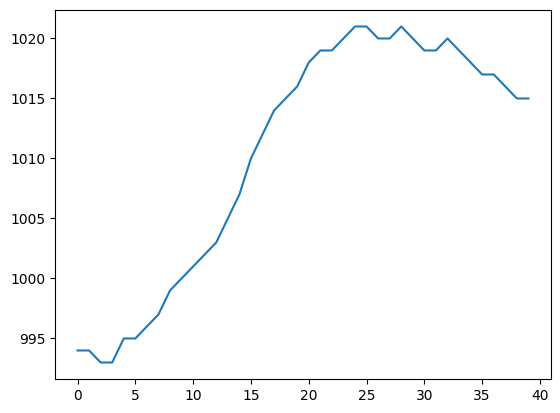

In [6]:
(current.pressure).plot()


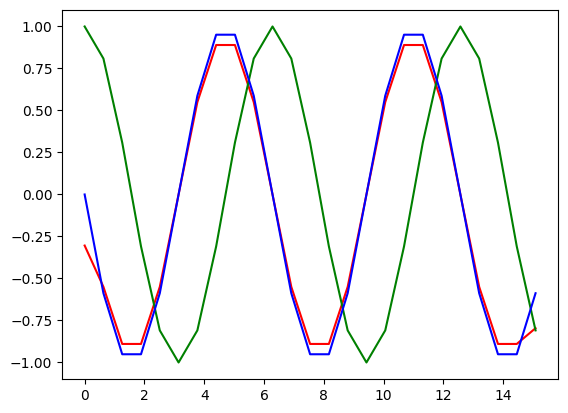

In [7]:
pi = np.pi
x = np.arange(0,5*pi,0.2*pi)
y = np.cos(x) 
# derivative dy/dx = -sin(x)
der = np.gradient(y,x)
plt.plot(x, der, 'r', x, y, 'g', x, -np.sin(x),'b')
plt.show()

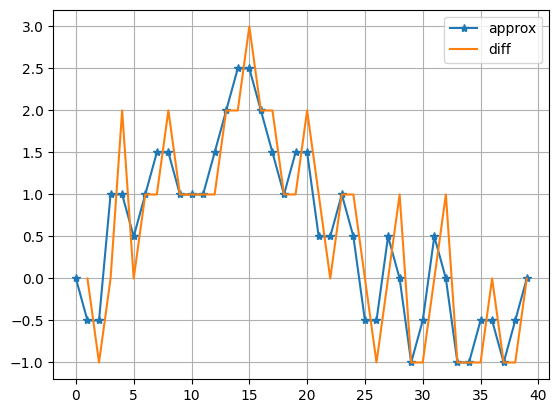

In [8]:
# derivative of pressure
dy = current.pressure#.diff()
#dy.plot()
# we sample a sin(x) function
dx = current.index.step
x = np.arange(0,40)
#current.pressure.diff().plot(label='diff')
# we calculate the derivative, with np.gradient
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
#plt.plot()
dy.diff().plot(x=x,label='diff')
plt.legend()
plt.grid()


In [9]:
dy.diff()

0     NaN
1     0.0
2    -1.0
3     0.0
4     2.0
     ... 
35   -1.0
36    0.0
37   -1.0
38   -1.0
39    0.0
Name: pressure, Length: 40, dtype: float64

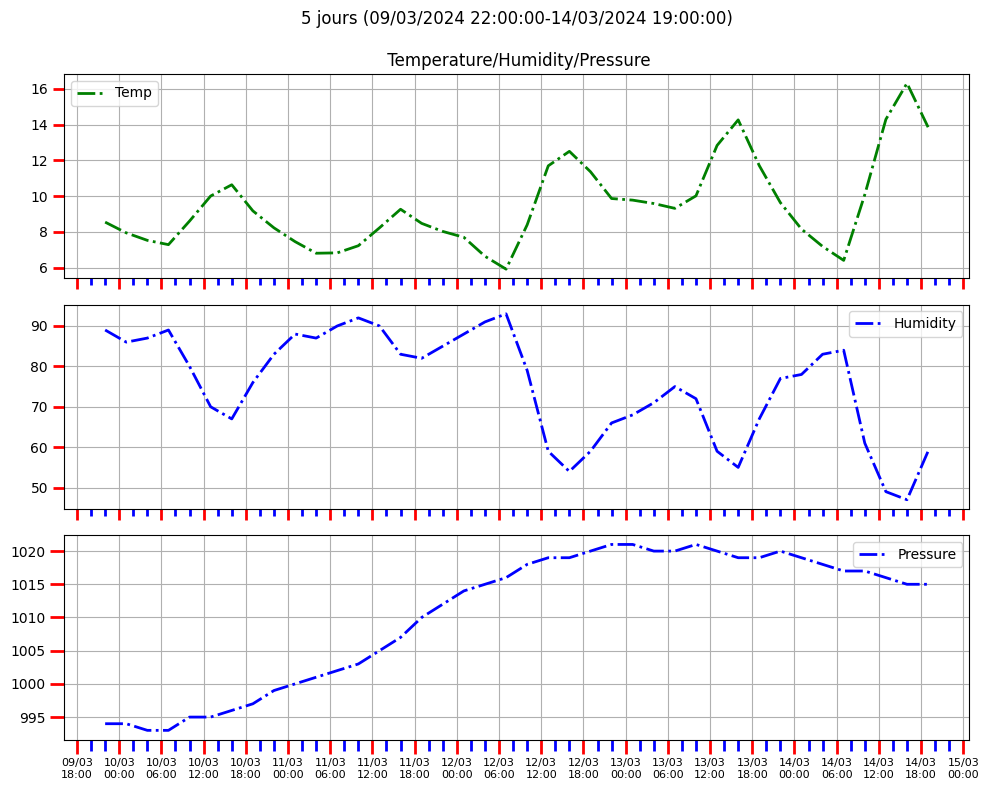

In [10]:
#fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True)
# the size of A4 paper
fig.set_size_inches(10, 8)

ax1.tick_params('x', labelsize=8)
ax2.tick_params('x', labelsize=8)
ax3.tick_params('x', labelsize=8)

# format affichage dates sur axe des x
formatter = DateFormatter('%d/%m\n%H:%M')
#ax1.xaxis.set_major_formatter(formatter)
#ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_formatter(formatter)

# nombre de ticks sur axe des x
major_ticks = 1/4                    # toutes les 6 heures pour 1/4, 12h pour 1/2
minor_ticks = major_ticks/3          # facteur div = 4  -> minor ticks toutes les 3 heures

# temperature
ax1.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax1.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  # ???? pas d'affichage des minor ticks ???
# format des ticks
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=8, color='r')
ax1.tick_params(which='minor', length=5, color='b')
#plot
ax1.plot(current.dates,current.temp,'g-.',label='Temp',linewidth=2)
#plt.plot(current.dates,current.temp_max,'r-.',label='Max',linewidth=2)
#plt.plot(current.dates,current.temp_min,'b-.',label='Min',linewidth=2)

# humidity
ax2.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax2.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8, color='r')
ax2.tick_params(which='minor', length=5, color='b')
ax2.plot(current.dates,current.humidity,'b-.',label='Humidity',linewidth=2)

# pression
ax3.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax3.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=10, color='r')
ax3.tick_params(which='minor', length=8, color='b')
ax3.plot(current.dates,current.pressure,'b-.',label='Pressure',linewidth=2)

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

ax1.set_title(f'5 jours ({debut}-{fin})\n\n Temperature/Humidity/Pressure')
#ax2.set_title(f'Humidity')
fig.tight_layout()


# tendances

## temp * pression / humidity
- plus de pression, moins d'humidité = meilleure tendance

In [11]:
'''Le point de rosée est une donnée thermodynamique caractérisant l'humidité dans un gaz. 
Le point de rosée de l'air est la température à laquelle la pression partielle de vapeur 
d'eau est égale à sa pression de vapeur saturante. Il s'agit donc de la température à 
laquelle il faut refroidir un volume d'air, à pression et humidité absolue constantes, 
pour qu'il devienne saturé donc il y a condensation.

La dépression du point de rosée est la différence entre la température et le point de rosée : (T-Tr)
 à un niveau de pression donnée de l'atmosphère terrestre
'''
import numpy as np
a, b = 17.27, 237.7

def alpha(T,phi):
    '''
    0 < T < 60
    0.01 < phi < 1
    '''
    return a*T/(b+T) + np.log(phi)

def dewpoint(T, phi): # phi : humidité relative
    f = alpha(T,phi)
    Tr = b*f/(a-f)
    return (T,Tr,T-Tr) #round(Tr,2), round(T-Tr,2)   # dewpoint, depression


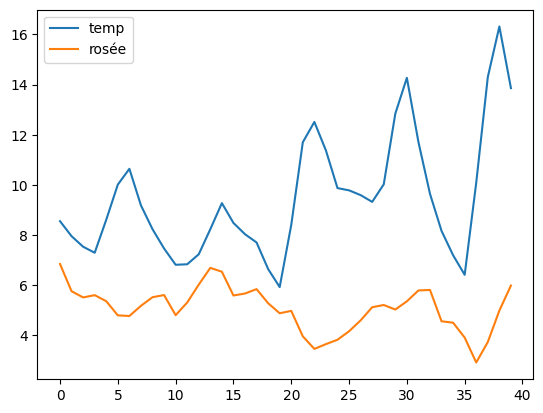

In [12]:
x = np.arange(40)
x_temp = current.temp
x_hum = current.humidity/100

rosee = dewpoint(x_temp,x_hum)
plt.plot(x,x_temp,label='temp')
plt.plot(x,rosee[1],label='rosée')
plt.legend()


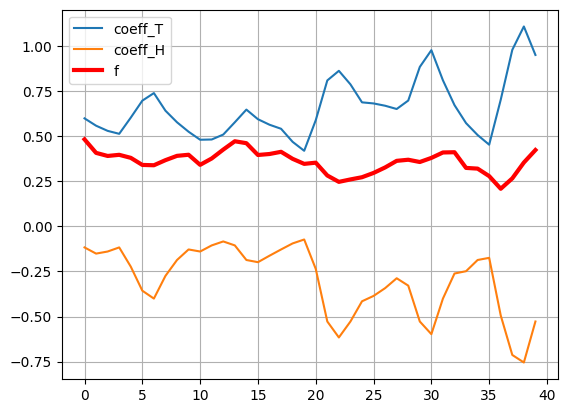

In [13]:
y_temp = a*x_temp/(b+x_temp)
y_hum = np.log(x_hum)
plt.plot(x,y_temp,label='coeff_T')
plt.plot(x,y_hum,label='coeff_H')  # valeurs négatives
f = y_temp+y_hum  # alpha()
plt.plot(x,f,label='f',lw=3,c='red')
plt.grid()
plt.legend()


(237.7, 17.27)

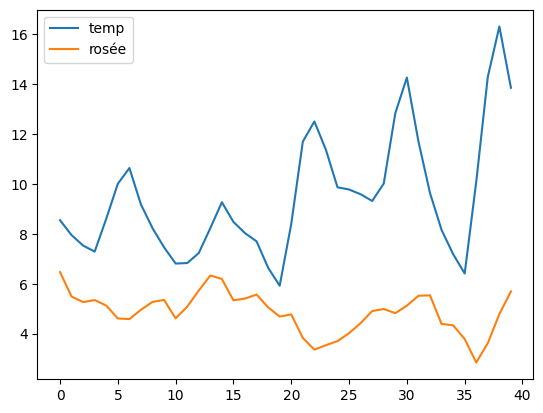

In [14]:
plt.plot(x,x_temp,label='temp')
plt.plot(x,b*f/(a+f),label='rosée')
plt.legend()
b,a


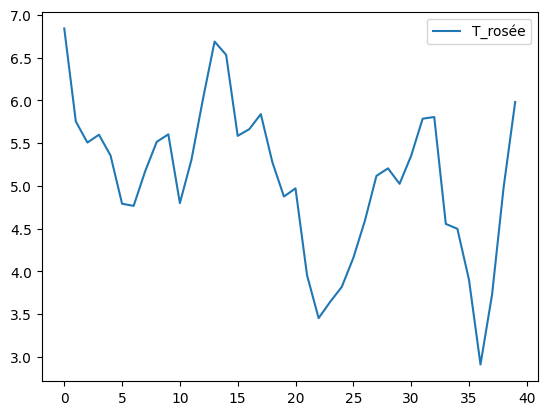

In [15]:
plt.plot(x,b*f/(a-f),label='T_rosée')
plt.legend()

In [16]:

f = y_temp+y_hum
f, alpha(y_temp,x_hum)


(0     0.483095
 1     0.408088
 2     0.391028
 3     0.397358
 4     0.380546
         ...   
 35    0.279134
 36    0.208937
 37    0.266654
 38    0.354522
 39    0.423879
 Length: 40, dtype: float64,
 0    -0.073078
 1    -0.110311
 2    -0.100820
 3    -0.079278
 4    -0.179394
         ...   
 35   -0.141468
 36   -0.443354
 37   -0.642440
 38   -0.674784
 39   -0.458777
 Length: 40, dtype: float64)

In [17]:
(x,y_hum)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 0    -0.116534
 1    -0.150823
 2    -0.139262
 3    -0.116534
 4    -0.223144
         ...   
 35   -0.174353
 36   -0.494296
 37   -0.713350
 38   -0.755023
 39   -0.527633
 Name: humidity, Length: 40, dtype: float64)

In [18]:
dewpoint(current.temp[0],current.humidity[0]/100)

(8.55, 6.840545422960331, 1.7094545770396694)

In [19]:
dewpt = dewpoint(current.temp ,current.humidity/100) 
dewpt

(0      8.55
 1      7.95
 2      7.53
 3      7.29
 4      8.61
       ...  
 35     6.41
 36    10.09
 37    14.30
 38    16.32
 39    13.86
 Name: temp, Length: 40, dtype: float64,
 0     6.840545
 1     5.752761
 2     5.506699
 3     5.597934
 4     5.355751
         ...   
 35    3.905042
 36    2.910981
 37    3.727718
 38    4.981814
 39    5.980958
 Length: 40, dtype: float64,
 0      1.709455
 1      2.197239
 2      2.023301
 3      1.692066
 4      3.254249
         ...    
 35     2.504958
 36     7.179019
 37    10.572282
 38    11.338186
 39     7.879042
 Length: 40, dtype: float64)

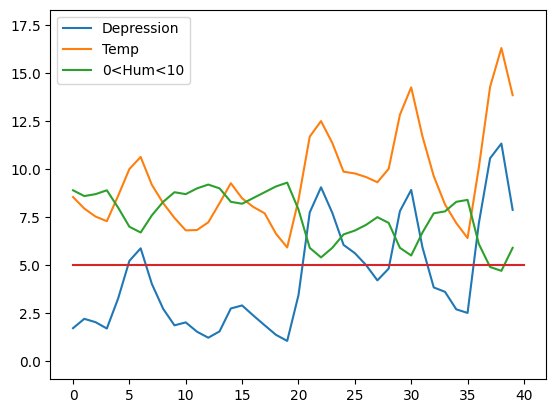

In [20]:
plt.plot(dewpt[2],label='Depression')
plt.plot(current.temp,label='Temp')
plt.plot(current.humidity/10,label='0<Hum<10')
plt.plot((0,40),(5,5))
plt.ylim(min(dewpt[2])-2,max(current.temp)+2)
plt.legend()
plt.show()


In [21]:
current.temp.head(),current.h_time.head()

(0    8.55
 1    7.95
 2    7.53
 3    7.29
 4    8.61
 Name: temp, dtype: float64,
 0    22
 1    01
 2    04
 3    07
 4    10
 Name: h_time, dtype: object)

In [22]:
current['dew_point'] = dewpt[1]
current[['h_time','temp','dew_point']]

,h_time,temp,dew_point
0,22,8.55,6.840545
1,01,7.95,5.752761
2,04,7.53,5.506699
3,07,7.29,5.597934
4,10,8.61,5.355751
...,...,...,...
35,07,6.41,3.905042
36,10,10.09,2.910981
37,13,14.30,3.727718
38,16,16.32,4.981814


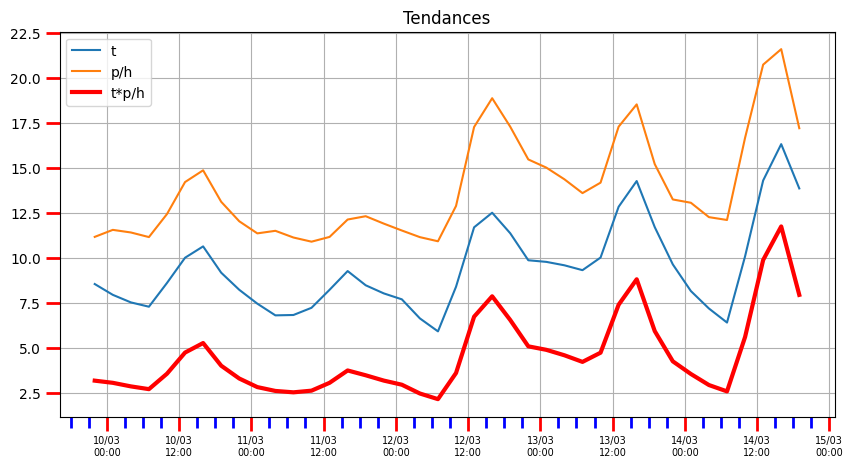

In [23]:
result1=current.temp  #*current.humidity*current.pressure
result2=(current.pressure)/(current.humidity*10)  #p/h est normalisé, on ramène le rapport autour de 1
result3=(current.temp)*result2

fig, ax = plt.subplots()

# nombre de ticks sur axe des x
major_ticks = 1/2                   # toutes les 6 heures pour 1/4, 12h pour 1/2, 3 heures pour 1/8
minor_ticks = major_ticks/4          # denominateur n = n minor ticks 


# format grid
fig.set_size_inches(10, 5)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=7)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, result1,label='t')
plt.plot(current.dates, result2*10,label='p/h')
plt.plot(current.dates, result3/3,label='t*p/h',lw=3,c='red')
plt.legend()
plt.title('Tendances')
plt.grid()

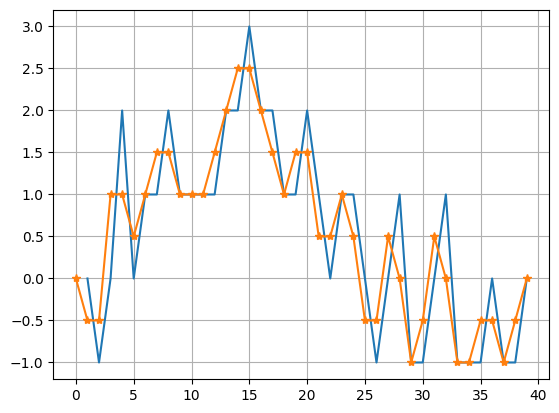

In [24]:
dy.diff().plot()
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
plt.grid()

In [25]:
len(dy)

40

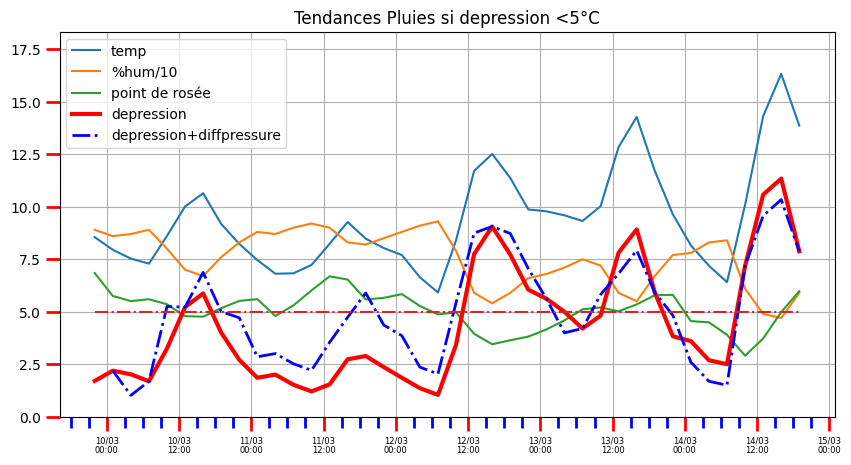

In [26]:
temp = current.temp  
# point de rosée
current['dewpoint']=dewpt[1]
point_rosee = dewpt[1]
# calcul de la dépression
depression = current.temp-point_rosee
current['depression']=depression
fig, ax = plt.subplots()

# format grid
fig.set_size_inches(10, 5)
# graduations axeX
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=6)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, temp,label='temp')
plt.plot(current.dates, current.humidity/10,label='%hum/10')
plt.plot(current.dates, point_rosee,label='point de rosée')#,lw=3,c='red')
# tendances pluie
#lbl = 'depr<5+ "pluie" if depression[0]<5 else ""
plt.plot(current.dates, depression,label="depression",lw=3,c='red')
plt.plot(current.dates, depression+dy.diff(),'-.',label="depression+diffpressure",lw=2,c='blue')
plt.plot((current.dates[0],current.dates[39]),(5,5),'-.')

plt.ylim(0,max(current.temp)+2)
plt.legend()
plt.title('Tendances Pluies si depression <5°C')
plt.grid()


In [27]:
current['tendances']=current['depression'].apply(lambda x: 'pluie' if x<5 else 'beau temps')

In [28]:
# 24 h
current[:20][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
0,09/03/2024 22:00:00,8.55,1.709455,pluie
1,10/03/2024 01:00:00,7.95,2.197239,pluie
2,10/03/2024 04:00:00,7.53,2.023301,pluie
3,10/03/2024 07:00:00,7.29,1.692066,pluie
4,10/03/2024 10:00:00,8.61,3.254249,pluie
5,10/03/2024 13:00:00,10.01,5.219035,beau temps
6,10/03/2024 16:00:00,10.64,5.874268,beau temps
7,10/03/2024 19:00:00,9.18,4.008513,pluie
8,10/03/2024 22:00:00,8.23,2.714952,pluie
9,11/03/2024 01:00:00,7.46,1.857458,pluie


In [29]:
current[20:40][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
20,12/03/2024 10:00:00,8.40,3.429321,pluie
21,12/03/2024 13:00:00,11.70,7.746400,beau temps
22,12/03/2024 16:00:00,12.51,9.057068,beau temps
23,12/03/2024 19:00:00,11.37,7.726232,beau temps
24,12/03/2024 22:00:00,9.87,6.052194,beau temps
25,13/03/2024 01:00:00,9.78,5.623209,beau temps
26,13/03/2024 04:00:00,9.59,4.998859,pluie
27,13/03/2024 07:00:00,9.32,4.203410,pluie
28,13/03/2024 10:00:00,10.02,4.815222,pluie
29,13/03/2024 13:00:00,12.84,7.816270,beau temps


In [30]:
current.h_date

0     09/03/2024 22:00:00
1     10/03/2024 01:00:00
2     10/03/2024 04:00:00
3     10/03/2024 07:00:00
4     10/03/2024 10:00:00
             ...         
35    14/03/2024 07:00:00
36    14/03/2024 10:00:00
37    14/03/2024 13:00:00
38    14/03/2024 16:00:00
39    14/03/2024 19:00:00
Name: h_date, Length: 40, dtype: object